<!-- Notes from meeting: 

actual arrest rate vs reported arrest rate (what we have)
 - some agencies not NIBRS-participating 
we do not not the police involvement rate 

think about how the ratios vary with different elements (size of reporting department)

if you look at reporting agency:

look at what percent of IPV incidents/total number of incidents reporting by agency and
do we have reason to believe this percent would change by agency (put the former race ratios in context)

theory: arrest rate by race (conditioned on offense type) should not vary with reporting department 

in presentation: emphasize - I have a code base, and I have a lot of flexibility in the sorts of questions I answer (i.e. in outlook talk about how my code base supports all the questions I could further ask)

1. I have a way to process the actual NIBRS data without ICPSR (can make tables akin to ICPSR or can make customizable tables)

2. can talk about some of the trade offs/decisions I had to make it creating the subset/filter

3. talk about performance of this framework: can talk about run-times/storage

4. give examples of the different types of analysis I can produce can run EDA about how reporting agencies differ, about how arrest rates differ

arc: I want to work with primary data and make my own decisions, how difficult is that? I have a result for this.  -->

<!-- This is quite a long notebook, simply because I utilized is as a journal and it shows many details of my thought process. I'm working on generating a more succinct version for documentation.  -->

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import math
from random import sample, seed
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
global_start_time = time.time()

In [4]:
## plot style options
from matplotlib import cycler
IPython_default = plt.rcParams.copy()
axisgrey = '#666565'
axisgrey2 = '#383838'
mycolors = ['#7a5195','#d04f89','#ff6959','#ffa600', '#228495','#00a17f','#83b138','#ffa600']
#mycolors = ['#7533bd', '#07ada7', '#de7ad4', '#d94e7a','#7ee6b7', '#66c464','#4287f5', '#b39bc9']
colors = cycler('color', mycolors)
plt.rc('axes', prop_cycle=colors, labelsize = 18, labelpad = 15, edgecolor = axisgrey )
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.color'] = axisgrey2
plt.rcParams['xtick.color'] = axisgrey2
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['legend.framealpha'] = 0
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rc('xtick', labelsize = 14)
plt.rc('ytick', labelsize = 14)
#plt.rc('font', family = 'DejaVu Sans')
#plt.rcParams.keys()

In [5]:
## makeshift progress bar
def printprogress(i, n, start_time, step = 10):
    t = time.time() - start_time
    if i == n-1:
        print("100 %% -- %d minutes %f seconds"%(math.floor(t/60),t%60))
    if (i<(n-1)-n%step) & (i%math.floor(n/step) == 0):
        print("%d %% -- %d minutes %f seconds"%((i+1)/math.floor((n-1)/step)*step, math.floor(t/60),t%60))

In [6]:
folder = "TX-2019/TX/" ## location of data tables


## Reporting agencies

Load data table: *agencies.csv* - contains information about the agencies (e.g. police departments) that reported the data in TX2019

In [7]:
agencies = pd.read_csv(folder + "agencies.csv")

Below I generate a **new variable** `NUMINC` for each unique `AGENCY_ID` the holds the count of the number of incidents reported by that agency. Examples of how `NUMINC` can be used to compare agencies by frequency of reporting are shown below. 

In [17]:
inc_counts = ag_incident["AGENCY_ID"].value_counts() # counts the number of incidents associated with an agency ID
inc = pd.DataFrame(inc_counts.values, index = inc_counts.index, columns = ["NUMINC"])

## merge with other agency info
inc = pd.merge(left = inc, left_index = True, right = agencies, right_on = 'AGENCY_ID')

In [18]:
## How many of each type of agency in the data?
inc["AGENCY_TYPE_NAME"].value_counts()

City                     423
County                   134
Other                     32
University or College     30
Name: AGENCY_TYPE_NAME, dtype: int64

Number of reporting agencies:  619


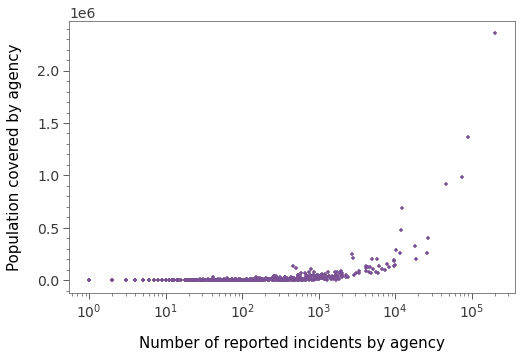

In [19]:
## new variable NUMINC can be used to compare agencies by frequency of reporting
fig, ax = plt.subplots(figsize = (8,5))
ax.scatter(inc["NUMINC"], inc["POPULATION"], s = 10, marker = "+")
ax.set_xlabel("Number of reported incidents by agency", fontsize = 15, labelpad = 15)
ax.set_ylabel("Population covered by agency", fontsize = 15, labelpad = 15)
print("Number of reporting agencies: ", len(inc))
ax.set_xscale('log')

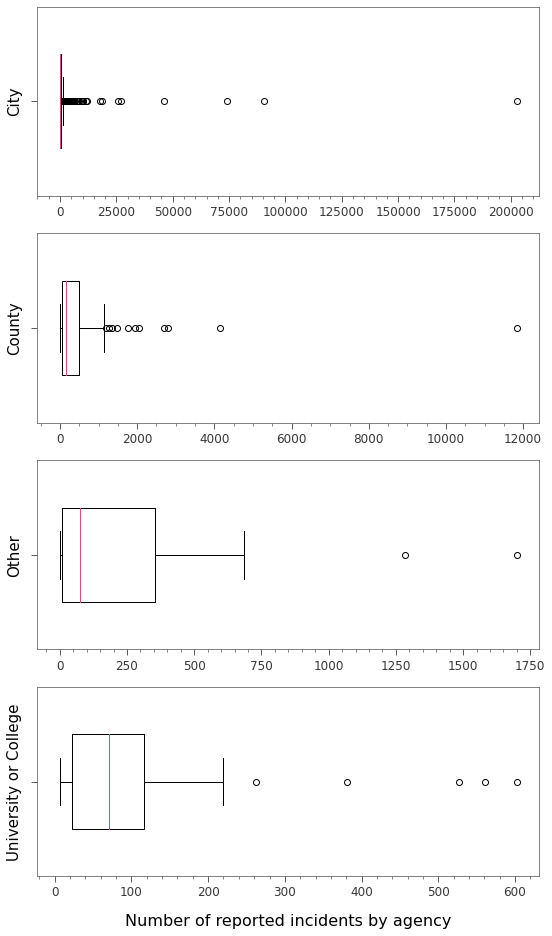

In [22]:
c = "AGENCY_TYPE_NAME"
n = len(inc[c].unique())
fig, axes = plt.subplots(n, figsize = (9, 4*n), sharex = False)
for i, each in enumerate(inc[c].unique()):
    axes[i].boxplot(inc.loc[inc[c]==each]["NUMINC"], vert = False, widths = 0.5)
    axes[i].set_ylabel(each, fontsize = 15)
    axes[i].tick_params(labelleft= False, labelsize = 12)
    
_ = axes[n-1].set_xlabel("Number of reported incidents by agency", fontsize = 16)

median: 0.026675 


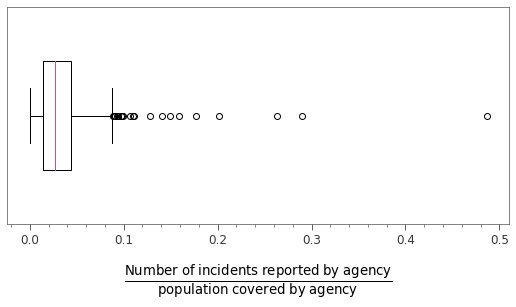

In [24]:
fig, ax = plt.subplots(figsize = (9,4))
boxplot =  ax.boxplot(inc.loc[inc['POPULATION']!=0]['NUMINC']/inc.loc[inc['POPULATION']!=0]['POPULATION'], vert = False, widths = 0.5)
ax.tick_params(left = False, labelleft = False, labelsize = 12)
_ = ax.set_xlabel(r"$\frac{\mathrm{Number\;of\;incidents\;reported\;by\;agency}}{\mathrm{population\;covered\;by \;agency}}$", fontsize = 19, labelpad = 15)
print("median: %f "%boxplot['medians'][0].get_xdata()[0])

#plt.savefig('Figures/agencies_normpart_boxplot', bbox_inches = 'tight')

In [25]:
print("Median no. of incidents reported by an agency", 
      inc[['AGENCY_ID','NUMINC']].drop_duplicates()['NUMINC'].median())
print("Mean no. of incidents reported by an agency", 
      inc[['AGENCY_ID','NUMINC']].drop_duplicates()['NUMINC'].mean())

Median no. of incidents reported by an agency 172.0
Mean no. of incidents reported by an agency 1455.9337641357029


# Assembling Data: 
## 1. Victim-offender relationship records

*NIBRS_VICTIM_OFFENDER_REL.csv* has columns `DATA_YEAR`,`VICTIM_ID`,`OFFENDER_ID`,`RELATIONSHIP_ID`,and `NIBRS_VICTIM_OFFENDER_ID`.

The values for `RELATIONSHIP_ID` are included in *NIBRS_RELATIONSHIP.csv* (see below)

In [26]:
#pandas.set_option('display.max_rows', None)
rel_types = pd.read_csv(folder+"NIBRS_RELATIONSHIP.csv")

## dictionary that converts RELATIONSHIP_ID -> RELATIONSHIP_NAME
drel_types = dict(zip(rel_types['RELATIONSHIP_ID'].to_list(),rel_types['RELATIONSHIP_NAME'].to_list()))

Load table: *NIBRS_VICTIM_OFFENDER_REL.csv*

In [27]:
vict = pd.read_csv(folder+"NIBRS_VICTIM_OFFENDER_REL.csv")

## 2. Connect victims to offenses
- NIBRS_VICTIM_OFFENDER_REL.csv contains `VICTIM_ID`
1. Join previous dataframe (NIBRS_VICTIM_OFFENDER_REL.csv) with NIBRS_VICTIM_OFFENSE on `VICTIM_ID` to get `OFFENSE_ID`(s) connected with each victim/offender pair
    - NIBRS_VICTIM_OFFENSE contains both `VICTIM_ID` and `OFFENSE_ID`
    - retain `OFFENDER_ID` from *NIBRS_VICTIM_OFFENDER_REL.csv* so I can get information on offender later
    - `OFFENSE_ID` can be matched to multiple unique values of `VICTIM_ID`, i.e. "many-to-one"
    
    
2. Join new dataframe from step 1 with NIBRS_OFFENSE on `OFFENSE_ID`

    - this adds more information about the offense, most notably `OFFENSE_TYPE_ID` (e.g. codes for simple assault, aggravated assault, etc.) and `INCIDENT_ID`
    - "one-to-one"

Codes/descriptions for `OFFENSE_TYPE_ID`

In [29]:
offense_types = pd.read_csv(folder+"NIBRS_OFFENSE_TYPE.csv")
## dictionary that converts OFFENSE_TYPE_ID -> OFFENSE_NAME
doffense_types = dict(zip(offense_types['OFFENSE_TYPE_ID'].to_list(),offense_types['OFFENSE_NAME'].to_list()))

Load table: *NIBRS_VICTIM_OFFENSE.csv*

In [1]:
NIBRS_victim_offense = pd.read_csv(folder+"NIBRS_VICTIM_OFFENSE.csv")

NameError: name 'pd' is not defined

In [31]:
vict_offense = pd.merge(left = NIBRS_victim_offense, 
                        #right = IPvict,
                        right = vict,
                        on = ['VICTIM_ID', 'DATA_YEAR'],
                        how = 'right',
)

Load table: *NIBRS_offense.csv*

In [33]:
NIBRS_offense = pd.read_csv(folder+"NIBRS_offense.csv")

Connect this new dataframe to the NIBRS_OFFENSE.csv using `OFFENDER_ID`:

In [35]:
vict_offns = pd.merge(left = NIBRS_offense, 
                     right = vict_offense, 
                     on = ['DATA_YEAR','OFFENSE_ID'])

## 3. Add Victim and Offender information (e.g., age, sex, race)

Load table: *NIBRS_victim.csv*

In [36]:
NIBRS_victim = pd.read_csv(folder+"NIBRS_victim.csv")

Load table: *NIBRS_offender.csv*

In [37]:
NIBRS_offender = pd.read_csv(folder + "NIBRS_offender.csv")

The same variable names `AGE_ID`, `AGE_NUM`, `SEX_CODE`, `RACE_ID`, `ETHNICITY_ID`, `AGE_RANGE_LOW_NUM`, `AGE_RANGE_HIGH_NUM` are used in both *NIBRS_victim.csv* and *NIBRS_offender.csv*

So I'll have to **rename the variables** before merging. 

In [38]:
## rename victim and offender variables by appending either 'VICTIM_' or 'OFFENDER_'
## in front of each variable listed
vmap = {}
omap = {}
for each in ['AGE_ID', 'AGE_NUM', 'SEX_CODE', 'RACE_ID', 'ETHNICITY_ID', 'AGE_RANGE_LOW_NUM', 'AGE_RANGE_HIGH_NUM']:
    vmap[each] = 'VICTIM_'+each
    omap[each] = 'OFFENDER_'+each

NIBRS_victim2 = NIBRS_victim.rename(columns = vmap)
NIBRS_offender2 = NIBRS_offender.rename(columns = omap)

Merge previous dataframe with 
- NIBRS_victim table on `VICTIM_ID` and `INCIDENT_ID`
- NIBRS_offender table on `OFFENDER_ID` and `INCIDENT_ID`

In [39]:
## merge with victim info
VO1 = pd.merge(left = vict_offns,
              right = NIBRS_victim2, 
              on = ['DATA_YEAR', 'VICTIM_ID', 'INCIDENT_ID'])

### merge with offender info
VO2 = pd.merge(left = VO1, 
              right = NIBRS_offender2, 
              on = ['DATA_YEAR', 'OFFENDER_ID', 'INCIDENT_ID'])

### Treatment of age variables

Something different from the ICPSR distribution is that **age is given via two variables as a range** instead of being given as a single value. I don't expect this to be an issue since I'm dealing with intimate partner relationships. Here's what `AGE_ID` corresponds to:

In [40]:
pd.read_csv(folder + "NIBRS_AGE.csv")

,AGE_ID,AGE_CODE,AGE_NAME
0,1,NN,Under 24 Hours
1,2,NB,1-6 Days Old
2,3,BB,7-364 Days Old
3,4,00,Unknown
4,5,AG,Age in Years
5,6,99,Over 98 Years Old
6,0,NS,Not Specified


If the age is known , it's given by `AGE_RANGE_LOW_NUM` or, equivalently, `AGE_NUM`. If `AGE_ID` is anything other than 5, `AGE_NUM`,`AGE_RANGE_LOW_NUM`, and `AGE_RANGE_HIGH_NUM` are all NaN. If `AGE_ID` is 5, `AGE_RANGE_HIGH_NUM` can be either 0 (if exact age is known) or greater than `AGE_RANGE_LOW_NUM` (thus giving an age range). 

If an age range is given (i.e. exact age is NOT known), then `AGE_NUM` is given as the midpoint of the range, rounding down to the nearest whole integer, i.e. 
```
if AGE_RANGE_HIGH_NUM>0:
    `AGE_NUM` = math.floor( (AGE_RANGE_LOW_NUM + AGE_RANGE_HIGH_NUM)/2 )
```

Below I create **new variables** `VICTIM_AGE` and `OFFENDER_AGE` to simplify things a bit further: these variables give the age as a single value if age is known, and -99 otherwise. I do this because I assume that the ages of the victim(s)/offender(s) will be known in a large majority of -- if not all -- IPV incidents. 

In [43]:
VO2['OFFENDER_AGE'] = np.where((VO2['OFFENDER_AGE_ID']==5)&(VO2['OFFENDER_AGE_RANGE_HIGH_NUM']==0), 
                               VO2['OFFENDER_AGE_RANGE_LOW_NUM'], 
                              -99)

VO2['VICTIM_AGE'] = np.where((VO2['VICTIM_AGE_ID']==5)&(VO2['VICTIM_AGE_RANGE_HIGH_NUM']==0), 
                               VO2['VICTIM_AGE_RANGE_LOW_NUM'], 
                              -99)

## 4. Merge with incident data

The arrestee data is connected with `INCIDENT_ID`, so in order to get information on whether or not an arrest occurred, I must merge the offense data with incident data. 

`INCIDENT_ID` already exists in my current dataframe from the NIBRS_offense table, but merging with incident data will give me other details of the incident (such as the reporting agency) and allow me to collect all the offenses, offenders, and victims under a single identifier

In [14]:
NIBRS_incident = pd.read_csv(folder+"NIBRS_incident.csv")
tot_no_incidents = len(NIBRS_incident['INCIDENT_ID'].unique())
print("Total no. of incidents in NIBRS-TX2019: ", tot_no_incidents)

Total no. of incidents in NIBRS-TX2019:  901223


In [45]:
# IVO = incident, victim, offender
IVO = pd.merge(left = NIBRS_incident, 
        right = VO2, 
        on = ['DATA_YEAR', 'INCIDENT_ID'],
        how = "inner") # how = 'right' produces the same result

## 5. Merge with arrest file

The associated files are 
- NIBRS_ARRESTEE.csv: tracks arrests related to incidents 
- NIBRS_ARRESTEE_WEAPON.csv: lists arrestees' weapon(s), if included in incident
    - includes `ARRESTEE_ID` as reference to NIBRS_ARRESTEE.csv    
- NIBRS_ARREST_TYPE.csv: reference for `ARREST_TYPE_ID` in  NIBRS_ARRESTEE.csv
- NIBRS_WEAPON.csv: reference for `WEAPON_ID` in NIBRS_ARRESTEE_WEAPON.csv

For now, I will only merge NIBRS_ARRESTEE.csv and not include the arrestee weapon table. 

In [57]:
arrest_types = pd.read_csv(folder + "NIBRS_ARREST_TYPE.csv")
arrest_types

,ARREST_TYPE_ID,ARREST_TYPE_CODE,ARREST_TYPE_NAME
0,1,O,On View
1,2,S,Summoned / Cited
2,3,T,Taken INTO Custody


In [58]:
darrest_types = dict(zip(arrest_types['ARREST_TYPE_ID'].to_list(),arrest_types['ARREST_TYPE_CODE'].to_list()))

Load table: *NIBRS_ARRESTEE.csv*

In [59]:
NIBRS_arrest = pd.read_csv(folder + "NIBRS_ARRESTEE.csv")

I'll **rename variables** `AGE_ID`, `AGE_NUM`, `SEX_CODE`, `RACE_ID`, `ETHNICITY_ID`, `AGE_RANGE_LOW_NUM`, and `AGE_RANGE_HIGH_NUM` for clarity and consistency with existing variable names like `VICTIM_AGE_ID` and `OFFENDER_AGE_ID`. I will also create a **new variable** `ARRESTEE_AGE` to be consistent with previously created variables `VICTIM_AGE` and `OFFENDER_AGE`. 

In [60]:
NIBRS_arrest = pd.read_csv(folder + "NIBRS_ARRESTEE.csv")

# rename existing variables
amap = {}
for each in ['AGE_ID', 'AGE_NUM', 'SEX_CODE', 'RACE_ID', 'ETHNICITY_ID', 'AGE_RANGE_LOW_NUM', 'AGE_RANGE_HIGH_NUM']:
    amap[each] = 'ARRESTEE_'+each
NIBRS_arrest = NIBRS_arrest.rename(columns = amap)

# generate new variable `ARRESTEE_AGE`
NIBRS_arrest['ARRESTEE_AGE'] = np.where((NIBRS_arrest['ARRESTEE_AGE_ID']==5) &
                                       (NIBRS_arrest['ARRESTEE_AGE_RANGE_HIGH_NUM']==0), 
                                       NIBRS_arrest['ARRESTEE_AGE_RANGE_LOW_NUM'], -99)

In [61]:
IVOA = pd.merge(left = IVO,
               right = NIBRS_arrest,
               on = ['DATA_YEAR', 'INCIDENT_ID', 'OFFENSE_TYPE_ID'], 
               how = "left") # left merge since **not all incidents will have an associated arrest record**

previous dataframe, n =  368722
new dataframe, n =  381752
number of unique incidents in previous dataframe:  245295
number of unique incidents in new dataframe:  245295


I'll create a **new variable** (`INC_APPEARS`) to indicate how many times the incident ID is repeated in the current dataframe. 

In [62]:
nappears = IVOA['INCIDENT_ID'].value_counts()

temp = pd.DataFrame(nappears.values, index = nappears.index, columns = ['INC_APPEARS'])

IVOA = pd.merge(left = IVOA, 
                right = temp,
                right_index = True, 
                left_on = 'INCIDENT_ID', 
                how = 'inner')

381752


Recall arrest file is merged on `INCIDENT_ID`. Therefore, `ARRESTEE_ID` doesn't correspond uniquely to `VICTIM_ID` or `OFFENDER_ID` (the purpose of `ARRESTEE_ID` is to connect arrestee information with *NIBRS_ARRESTEE_WEAPON.csv*. <font color = red> **The way to determine which offender is which arrestee is through offense type, age, sex, race, and ethnicity. Of course, this is an issue if the two arrestees are of the same age, sex, race, and ethnicity and committed the same offense.** </font>

# Selection of IPV-related offenses: Criteria

<!-- Want to ultimately get information on 
- Did arrest occur for $i$th offender? 
- What are characteristics of $i$th offender?
- (Eventually), what are characteristics of $i$th offender's offense?

Interested in offenders who
- Committed IPV-related offenses
- Are related to at least one victim by IP relationship

Some questions to consider down the line:

**Question**: Do I mark dual arrests (arrest of both victim/offender, which is problematic in cases of IPV) in a special way? Do I exclude them for simplicity (i.e. focus on cases where a single offender was arrested)?

**Question**: Should I compare arrest rates in simple cases, at least to start (i.e. single offender/victim)? How many incidents with IPV-related offenses are "simple?" 

To answer the latter question,--> I first need the <font color = blue>subset of offenses with at least one IPV-related offense </font>, where an IPV-related offense entails an DV-related offense committed by an offender in an IP relationship with the victim (two selection criteria). 

## Victim-Offender Relationship

<!-- **Question**: Should I include ex-boyfriends/ex-girlfriends and ex-spouses?

Note: Common-law marriage is a legal framework where a couple may be considered married without having formally registered their relation as a civil or religious marriage. 

From the [NIBRS User Manual](https://www.fbi.gov/file-repository/ucr/ucr-2019-1-nibrs-user-manua-093020.pdf/view): 

*The agency should use the Victim Was Offender category when a participant in the incident was
a victim and offender in the incident, such as domestic disputes where both husband and wife
are charged with assault, double murders (two people kill each other), or barroom brawls
where many participants are arrested*

**Question**: Should I include cases where the victim was marked as both a victim and an offender? 
-->

For now, I will include 
- victim was spouse (RELATIONSHIP_ID = 21)
- victim was boyfriend/girlfriend (RELATIONSHIP_ID = 3)
- victim was common-law spouse (RELATIONSHIP_ID = 6) 
- victim was offender (RELATIONSHIP_ID = 25)
<!--
I would like to include *victim was offender* cases because I do not want to exclude cases where the assault perpetrated by the victim failed to be identified as self-defense. Police response in nuanced situations is the very focus of this research project. However, I am not as interested in police response to incidents involving ex-relationships, though in general it would be another interesting factor to consider. -->

## DV-related offenses

In [72]:
## selected DV-related offense codes - anything that may be related to IPV
DVoffn_codes = [62, 20, 27,44,51, 49, 5, 26, 64, 32, 59, 60, 29, 40, 4, 43, 56, 36, 6]

## selected DV-related offense codes - a more conservative/cautious list
## **this is the one I end up using (see previous Notebooks for justification)
DVoffn_codes2 = [20,27,44,51, 32, 59, 60, 29, 40, 4, 43, 56, 36, 6] 


## Selection of IPV-related offenses: Implementation

In order to select "IPV-related offenses", I need to find incidents with DV-related offenses (from the conservative list above) that occurred between a victim and offender related by one of my endorsed IP relationship types. 

This amounts to me selecting incidents where

* *at least* one of the offenses is in my endorse (conservative) list of DV-related offenses

AND 

* *at least* one of the relationships tied to this offense is boyfriend/girlfriend, spouse, or common-law spouse. 

<!--other values of `NIBRS_VICTIM_OFFENDER_ID` and thus information about other offenses, offenders, and, victims in the incident will not be excluded as they were in *IPvict*. This is so that I can ask questions like "How many offenders are typical in an incident?" and "How do I identify and mark dual arrests?" For example, in the case that a boyfriend and girlfriend both committed simple assault, there will be four unique values of `NIBRS_VICTIM_OFFENDER_ID`.-->

I found one way to do this is to create a **new variable** `IPVOFFENSE`, iterate over all incidents, and, for all incidents meeting the above criteria, all rows with that incident ID are flagged with `IPVOFFENSE=True`. Then a new dataframe is generated selecting only rows with `IPVOFFENSE=True`

In [88]:
n = len(IVOA['INCIDENT_ID'].unique())

# variable to mark incidents with IPV-related offenses
IVOA['IPVOFFENSE'] = 'No'

# iterate over incidents
start_time = time.time()
for i,INCIDENT_ID in enumerate(IVOA['INCIDENT_ID'].unique()): 
    # makeshift progress bar
    t = time.time() - start_time
    if i%round((n-1)/10) == 0:
        if t>60:
            print("%d %% -- %d minutes %f seconds"%(i/round((n-1)/10)*10, math.floor(t/60),t%60))
        else: 
            print("%d %% -- 0 minutes %f seconds"%(i/round((n-1)/10)*10, t%60))
    
    incident = IVOA[IVOA['INCIDENT_ID']==INCIDENT_ID]
    DVoffense = []
   
    # check to see if incident includes DV-related offenses from conservative list; hold such offenses in a list
    for offense in incident['OFFENSE_TYPE_ID'].unique():
        if offense in DVoffn_codes2:
            DVoffense.append(offense)
    # if DV-related offenses are included in the incident, 
    if len(DVoffense)>0:
        # is *at least one* of the DV-related offenses tied to IP relationship?
        for offense in DVoffense:
            rels_for_this_offense = incident[incident['OFFENSE_TYPE_ID']==offense]['RELATIONSHIP_ID'].unique()
            for rel in rels_for_this_offense: 
                if rel in [21,3,6]:
                    IVOA.loc[IVOA['INCIDENT_ID']==INCIDENT_ID, 'IPVOFFENSE'] ='Yes' # marked all rows of the incident to be included

0 % -- 0 minutes 0.015612 seconds
10 % -- 2 minutes 25.650806 seconds
20 % -- 4 minutes 38.995883 seconds
30 % -- 6 minutes 28.470449 seconds
40 % -- 8 minutes 12.974585 seconds
50 % -- 9 minutes 22.932722 seconds
60 % -- 11 minutes 17.562531 seconds
70 % -- 13 minutes 23.130336 seconds
80 % -- 15 minutes 22.268219 seconds
90 % -- 17 minutes 28.692902 seconds
100 % -- 19 minutes 42.888166 seconds


New data subset:

In [93]:
IPIVOA = IVOA[IVOA['IPVOFFENSE']=='Yes']

In [94]:
print("no. incidents in previous dataframe: ",len(IVOA['INCIDENT_ID'].unique()))
print("no.incidents in new dataframe: ", len(IPIVOA['INCIDENT_ID'].unique()))

no. incidents in previous dataframe:  245295
no.incidents in new dataframe:  65816


<!--**How many offenders are typical in an incident including an IPV-related offense?**

This is asked as part of investigating the question above of "How many incidents with IPV-related offenses are 'simple?'" If I decide to select only "simple" cases, I want to understand the affects of this decision (e.g., How many incidents am I overlooking?)-->

A **new variable** `NOFFENDERS` is created to represent how many unique values of `OFFENDER_ID` are associated with a given `INCIDENT_ID`, i.e. how many offenders for that incident. 

In [95]:
## How many unique values of OFFENDER_ID for a given INCIDENT_ID?
IPIVOA['NOFFENDERS'] = -999

start_time = time.time()
n = len(IPIVOA['INCIDENT_ID'].unique())
for i, INCIDENT_ID in enumerate(IPIVOA['INCIDENT_ID'].unique()):
    printprogress(i,n, start_time)
    noffenders = len(IPIVOA[IPIVOA['INCIDENT_ID']==INCIDENT_ID]['OFFENDER_ID'].unique())
    IPIVOA.loc[IPIVOA['INCIDENT_ID']==INCIDENT_ID, 'NOFFENDERS'] = noffenders

0 % -- 0 minutes 0.000000 seconds
10 % -- 0 minutes 11.453482 seconds
20 % -- 0 minutes 23.154202 seconds
30 % -- 0 minutes 34.646725 seconds
40 % -- 0 minutes 48.451501 seconds
50 % -- 1 minutes 2.865638 seconds
60 % -- 1 minutes 15.509335 seconds
70 % -- 1 minutes 29.330123 seconds
80 % -- 1 minutes 43.042338 seconds
90 % -- 1 minutes 55.884839 seconds
100 % -- 2 minutes 10.423370 seconds


**Exclude cases where NOFFENDERS > 2**

New data subset:

In [103]:
IPIVOA2 = IPIVOA[IPIVOA['NOFFENDERS']<=2]
print("length of previous dataframe: ",len(IPIVOA))
print("length of new dataframe: ",len(IPIVOA2))

length of previous dataframe:  85614
length of new dataframe:  82597


**Distinguish between two-offender cases: Victim was Offender versus some other offender (New Variable)**

**New variable** `RECIPROCATED`: if OFFENDER_ID appears in "Victim Was Offender" row and a "Victim Was {IP Relationship Type X}" row and the VICTIM_ID in the "Victim Was {IP Relationship Type X}" row also appears in a 'Victim Was Offender" row 

Can later classify based on "single offender", "reciprocated (same offense)" and "reciprocated (different offenses)" to distinguish between examples like that above where one intimate partner committed a more severe offense (e.g. one spouse commits aggravated assault while the other commits simple assault). This would be useful if I decide to look at arrest rates in only in cases of "single offender" and "reciprocated (different offenses)." 

In [104]:
IPIVOA2['RECIPROCATED'] = 'No'
start_time = time.time()
n = len(IPIVOA2['INCIDENT_ID'].unique())
for i, INCIDENT_ID in enumerate(IPIVOA2['INCIDENT_ID'].unique()):
    printprogress(i,n,start_time)
    incident = IPIVOA2[IPIVOA2['INCIDENT_ID']==INCIDENT_ID]
    for OFFENDER_ID in incident['OFFENDER_ID'].unique():
        if 25 in incident[incident['OFFENDER_ID']==OFFENDER_ID]['RELATIONSHIP_ID'].unique():
            IPTYPE = list(set([21,6,3])&set(incident[incident['OFFENDER_ID']==OFFENDER_ID]['RELATIONSHIP_ID'].unique()))
            if (len(IPTYPE)>0) & (len(IPTYPE)<2):
                VICTIM_IDs = incident[(incident['OFFENDER_ID']==OFFENDER_ID)&
                                      (incident['RELATIONSHIP_ID']==IPTYPE[0])]['VICTIM_ID'].unique()
                
                VICTIM_ID = VICTIM_IDs[0]
                if len(VICTIM_IDs)>1:
                    print('warning: more than one VICTIM_ID per IP relationship with offender')
                
                if 25 in incident[incident['VICTIM_ID']==VICTIM_ID]['RELATIONSHIP_ID'].unique():
                    
                    # labels only certain rows of the incident
                    IPIVOA2.loc[(IPIVOA2['OFFENDER_ID']==OFFENDER_ID)
                               &(IPIVOA2['VICTIM_ID']==VICTIM_ID), 'RECIPROCATED'] = 'Yes' 
                
            if (len(IPTYPE)>=2):
                print('warning: more than one IP type per offender')

0 % -- 0 minutes 0.002204 seconds
10 % -- 0 minutes 21.581696 seconds
20 % -- 0 minutes 35.275775 seconds
30 % -- 0 minutes 50.300396 seconds
40 % -- 1 minutes 10.804882 seconds
50 % -- 1 minutes 30.613839 seconds
60 % -- 1 minutes 45.473462 seconds
70 % -- 1 minutes 59.728593 seconds
80 % -- 2 minutes 13.231937 seconds
90 % -- 2 minutes 27.664065 seconds
100 % -- 2 minutes 45.542592 seconds


For this particular data subset, about half of the incidents with IPV-related offenses with two offenders are cases of 'domestic dispute' where two offenders were also two victims. 

**For incidents with two offenders, I will include only these 'domestic dispute' cases.** The variable `INCLUDE` here is just a temporary flag to simplify the selection, but does not need to be retained in the final dataframe. 

In [109]:
IPIVOA2['INCLUDE'] = 'No'
IPIVOA2.loc[IPIVOA2['NOFFENDERS']==1,'INCLUDE'] = 'Yes'

select_incident_ids = IPIVOA2[(IPIVOA2['NOFFENDERS']==2) & (IPIVOA2['RECIPROCATED']=='Yes')]['INCIDENT_ID'].unique()
n = len(select_incident_ids)
start_time = time.time()
for i, INCIDENT_ID in enumerate(select_incident_ids):
    printprogress(i,n,start_time)
    IPIVOA2.loc[IPIVOA2['INCIDENT_ID']==INCIDENT_ID, 'INCLUDE'] = 'Yes'

0 % -- 0 minutes 0.000000 seconds
10 % -- 0 minutes 0.595880 seconds
20 % -- 0 minutes 1.208142 seconds
30 % -- 0 minutes 1.758514 seconds
40 % -- 0 minutes 2.257835 seconds
50 % -- 0 minutes 2.759890 seconds
60 % -- 0 minutes 3.255116 seconds
70 % -- 0 minutes 3.759774 seconds
80 % -- 0 minutes 4.172711 seconds
90 % -- 0 minutes 4.582906 seconds
100 % -- 0 minutes 5.015006 seconds


New data subset:

In [110]:
IPIVOA3 = IPIVOA2[IPIVOA2['INCLUDE']=='Yes']
print("length of previous dataframe: ", len(IPIVOA2))
print("no. of incidents in previous dataframe: ", len(IPIVOA2['INCIDENT_ID'].unique()))
print("length of new dataframe: ", len(IPIVOA3))
print("no. of incidents in new dataframe: ", len(IPIVOA3['INCIDENT_ID'].unique()))

length of previous dataframe:  82597
no. of incidents in previous dataframe:  65433
length of new dataframe:  77209
no. of incidents in new dataframe:  63800


The number of incidents with one or two offenders:

In [111]:
IPIVOA3[['INCIDENT_ID', 'NOFFENDERS']].drop_duplicates()['NOFFENDERS'].value_counts()

1    62034
2     1766
Name: NOFFENDERS, dtype: int64

<br><br>

In [163]:
total_run_time = time.time() - global_start_time
print(" Notebook run time -- %d minutes %f seconds"%(math.floor(total_run_time/60),total_run_time%60))

 Notebook run time -- 41 minutes 43.105246 seconds


In [164]:
from platform import python_version

python_version()

'3.8.5'